In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.manual_seed(2)

In [ ]:

N = 1000
d = 20000
dt = 1/100
h = .693

m  = torch.ones(d, device=device)
a  = lambda t: d ** (1/2) * (1-t)
ap = lambda t: -d ** (1/2)
b  = lambda t: t
bp = lambda t: 1
c  = n ** (1/2)


np.random.seed(2)
xp = np.random.randn(N,d).T * c
x = torch.tensor(xp, device=device, dtype = torch.float)
xs = [x.cpu().numpy()]
ms = [np.sum(xs[0], axis=0)]
ps = [np.mean(ms[0]>0)]

def bf(x, t):
    x_coef    = (a(t) * ap(t) + b(t) * bp(t)) / (a(t)**2 + b(t)**2)
    tanh_coef = a(t) * (bp(t) * a(t) - b(t) * ap(t)) / (a(t)**2 + b(t)**2)
    tanh_term = torch.tanh(h + b(t) * (m @ x) / (a(t)**2 + b(t)**2))
    return x_coef * x + tanh_coef * torch.outer(m, tanh_term)

ts = np.arange(0, 1, dt)
for t in ts:
    x = x + bf(x, t) * dt
    mm = np.sum(x.cpu().numpy(), axis=0)
    p = np.mean(mm > 0)
    ps.append(p)
    # print(t)
    #xs.append(x.cpu().numpy())

ps = np.array(ps)

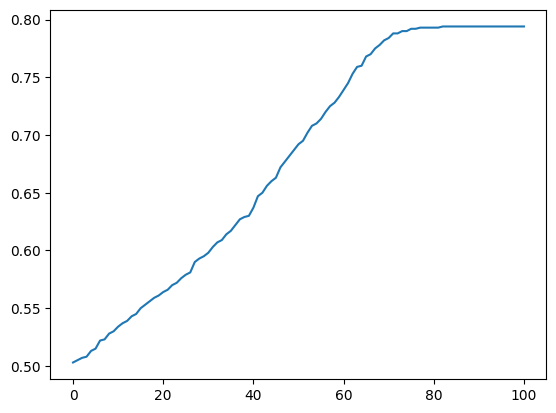

In [2]:
plt.plot(ps)

In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.manual_seed(2)

In [ ]:
def run(N=1000, d=100,n_steps=100, h=0.693, rescale=False):
    # np.random.seed(2)
    m  = torch.ones(d, device=device)
    a_coef = d if rescale else 1.
    a  = lambda t: a_coef ** (1/2) * (1-t)
    ap = lambda t: - a_coef ** (1/2)
    b  = lambda t: t
    bp = lambda t: 1
    dt = 1./n_steps
    xp = np.random.randn(N,d).T * a_coef ** (1/2)
    x = torch.tensor(xp, device=device, dtype = torch.float)
    xs = [x.cpu().numpy()]
    ms = [np.sum(xs[0], axis=0)]
    ps = [np.mean(ms[0]>0)]

    def bf(x, t):
        x_coef    = (a(t) * ap(t) + b(t) * bp(t)) / (a(t)**2 + b(t)**2)
        tanh_coef = a(t) * (bp(t) * a(t) - b(t) * ap(t)) / (a(t)**2 + b(t)**2)
        tanh_term = torch.tanh(h + b(t) * (m @ x) / (a(t)**2 + b(t)**2))
        return x_coef * x + tanh_coef * torch.outer(m, tanh_term)

    ts = np.arange(0, 1, dt)
    for t in ts:
        x = x + bf(x, t) * dt
        mm = np.sum(x.cpu().numpy(), axis=0)
        p = np.mean(mm > 0)
        ps.append(p)
        # print(t)
        #xs.append(x.cpu().numpy())

    return np.array(ps)[-1]

In [4]:
def run(N=1000, d=100,n_steps=100, h=0.693, rescale=False):
    # np.random.seed(2)
    m  = torch.ones(d, device=device)
    a_coef = d if rescale else 1.
    a  = lambda t: a_coef ** (1/2) * (1-t)
    ap = lambda t: - a_coef ** (1/2)
    b  = lambda t: t
    bp = lambda t: 1
    dt = 1./n_steps
    x = np.random.randn(N,d).T * a_coef ** (1/2)
    m = x.mean(axis=0)

    def bf(m, t):
        x_coef    = (a(t) * ap(t) + b(t) * bp(t)) / (a(t)**2 + b(t)**2)
        tanh_coef = a(t) * (bp(t) * a(t) - b(t) * ap(t)) / (a(t)**2 + b(t)**2)
        tanh_term = np.tanh(h + b(t) * m * d / (a(t)**2 + b(t)**2))
        return x_coef * m + tanh_coef *  tanh_term

    ts = np.arange(0, 1, dt)
    for t in ts:
        m = m + bf(m, t) * dt

    return m.mean()

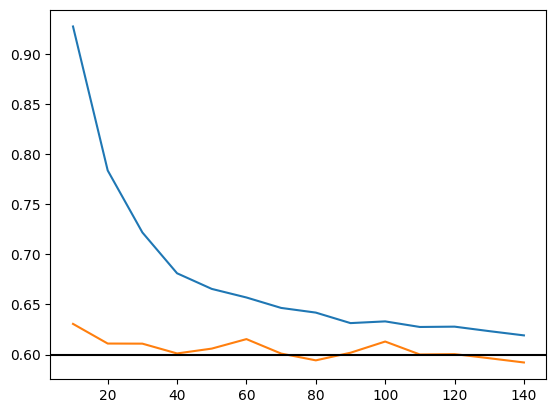

In [127]:
n_steps_ls = np.arange(10,150,10)
d = 800
h = 0.693
p = 1/(1 + np.exp(-2*h))
m_star = 2*p-1
N = 30000
plt.plot(n_steps_ls,[run(n_steps=n_steps, d=d, h=h, N=N) for n_steps in n_steps_ls], label='VP')
plt.plot(n_steps_ls,[run(n_steps=n_steps, d=d, h=h, N=N, rescale=True) for n_steps in n_steps_ls], label='VE')
# p = 1/(1+np.exp(-2*h))
plt.axhline(m_star, color='black')

In [18]:
n_steps_ls = np.arange(10,50,5)
d_ls = np.arange(1, 100, 10)**2
rescale_ls = [True, False]

h = 0.693
p = 1/(1 + np.exp(-2*h))
m_star = 2*p-1
N = 10000

data = [
    [rescale, n_steps, d, run(n_steps=n_steps, d=d, h=h, N=N, rescale=rescale)]
    for rescale in rescale_ls for n_steps in n_steps_ls for d in d_ls
]

In [19]:
import pandas as pd

/var/folders/ny/gkh5wqms1jx8vp88bygz1szr0000gn/T/ipykernel_70253/4291009173.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to accommodate the color bar


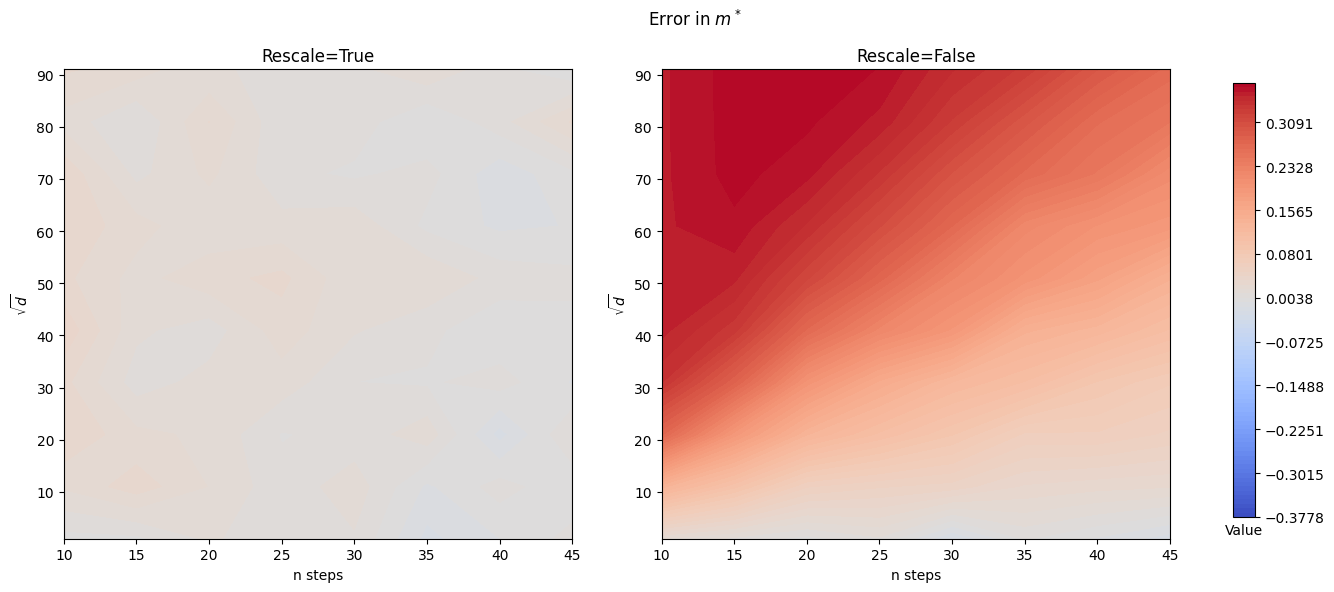

In [27]:
df = pd.DataFrame(data, columns=['rescale', 'n_steps', 'd', 'value'])
df['value'] = df['value'] - m_star
df['sqrt d'] = df['d'].pow(0.5)
# Pivot the data for rescale=True
df_true = df[df['rescale'] == True].pivot(columns='n_steps', index='sqrt d',values='value')

# Pivot the data for rescale=False
df_false = df[df['rescale'] == False].pivot(columns='n_steps', index='sqrt d',values='value')


# Determine the common range for the color bar
vmax= df['value'].abs().max()
vmin = -vmax

# # Generate contour plots
# fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Generate contour plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Contour plot for rescale=True
X_true, Y_true = np.meshgrid(df_true.columns, df_true.index)
Z_true = df_true.values
contour1 = ax[0].contourf(X_true, Y_true, Z_true, cmap='coolwarm', levels=np.linspace(vmin,vmax, 100))
ax[0].set_title('Rescale=True')
ax[0].set_ylabel(r'$\sqrt{d}$')
ax[0].set_xlabel('n steps')

# Contour plot for rescale=False
X_false, Y_false = np.meshgrid(df_false.columns, df_false.index)
Z_false = df_false.values
contour2 = ax[1].contourf(X_false, Y_false, Z_false, cmap='coolwarm', levels=np.linspace(vmin,vmax, 100))
ax[1].set_title('Rescale=False')
ax[1].set_ylabel(r'$\sqrt{d}$')
ax[1].set_xlabel('n steps')

# Add a single color bar for both plots
cbar = fig.colorbar(contour2, ax=ax, location='right', fraction=0.02, pad=0.1)
cbar.ax.set_xlabel('Value')

plt.suptitle(r"Error in $m^*$")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to accommodate the color bar
plt.show()
